# phygnn-gan example

Here's a simple method for making a generative-adversarial network by using a binary classifier (discriminator) in the custom loss function provided to the phygnn model.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy

from rex import init_logger
from rex import Resource

from phygnn import PhysicsGuidedNeuralNetwork

In [2]:
init_logger('phygnn', log_level='INFO', log_file=None)

<Logger phygnn (INFO)>

## Import NSRDB solar data
The data includes 30-minute clearsky and all-sky GHI profiles from 9 locations for 1998-2019 inclusive.

In [3]:
with Resource('./nsrdb_data.h5') as res:
    df = pd.DataFrame({'ghi': res['ghi'], 'clearsky_ghi': res['clearsky_ghi']})

df['ghi'] = np.roll(df['ghi'], -7).astype(np.float32)
df['clearsky_ghi'] = np.roll(df['clearsky_ghi'], -7).astype(np.float32)
    
df.describe()

ghi  clearsky_ghi
count  3.471120e+06  3.471120e+06
mean   1.865992e+02  2.387738e+02
std    2.741522e+02  3.133253e+02
min    0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00
75%    3.240000e+02  4.760000e+02
max    1.100000e+03  1.100000e+03

<AxesSubplot:>

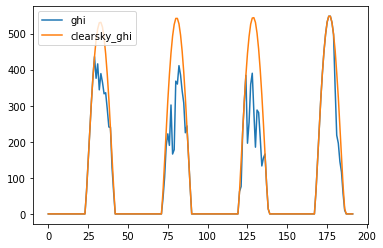

In [4]:
df.iloc[:192, :].plot()

## Shape the data
The data will be stored 2D arrays where each row is one day of data containing 30-minute profiles for clearsky and all-sky GHI along with some physical metrics of the all-sky profile such as total cumulative GHI, maximum GHI, ramp rates, etc... Our goal is to use the physical metrics to condition the generator (CGAN) into producing realistic solar profiles with the desired physical properties.

In [5]:
n_days = int(len(df) / 48)
real_data = np.full((n_days, 96 + 4), np.nan, dtype=np.float32)

for i in range(n_days):
    i0 = i * 48
    i1 = i0 + 48
    real_data[i, 0:48] = df.iloc[i0:i1]['clearsky_ghi'].values
    
    # extra prediction features based on the physical attributes of the real solar profile
    real_data[i, 48] = df.iloc[i0:i1]['ghi'].values.max()
    real_data[i, 49] = df.iloc[i0:i1]['ghi'].values.sum()
    real_data[i, 50] = np.nanmax(np.abs(np.diff(df.iloc[i0:i1]['ghi'].values)))
    real_data[i, 51] = np.nanmean(np.abs(np.diff(df.iloc[i0:i1]['ghi'].values)))
    
    real_data[i, 52:] = df.iloc[i0:i1]['ghi'].values

# global variables for indexing
I0 = 48
I1 = 52

assert np.isnan(real_data).sum() == 0

In [6]:
test_index = sorted(np.random.choice(n_days, 200))
train_index = list(set(range(n_days)) - set(test_index))
test_data = real_data[test_index, :]
real_data = real_data[train_index, :]

display(test_data.shape, real_data.shape)

(200, 100)

(72115, 100)

i: 0 max: 436.0 sum: 5077.0 max_diff: 111.00 mean_diff: 22.30 
i: 1 max: 411.0 sum: 4273.0 max_diff: 190.00 mean_diff: 25.79 
i: 2 max: 390.0 sum: 4060.0 max_diff: 188.00 mean_diff: 30.38 
i: 3 max: 548.0 sum: 5852.0 max_diff: 148.00 mean_diff: 23.32 
i: 4 max: 574.0 sum: 6832.0 max_diff: 91.00 mean_diff: 24.43 


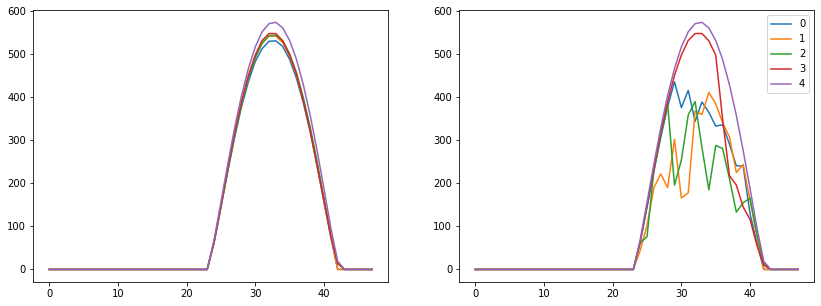

In [7]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(5):
    ax1.plot(real_data[i, 0:48])
    ax2.plot(real_data[i, I1:])
    print('i: {} max: {} sum: {} max_diff: {:.2f} mean_diff: {:.2f} '
          .format(i, real_data[i, 48], real_data[i, 49], 
                  real_data[i, 50], real_data[i, 51]))
    
plt.legend(range(5))

In [8]:
g_features = real_data[:, 0:I1]  # clearsky profiles
g_known = real_data[:, I1:] # all-sky profiles

In [9]:
# clearsky profiles + [max_ghi, sum_ghi, max_diff, mean_diff]
g_features[0, :]

array([   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,   63.      ,
        144.      ,  228.      ,  307.      ,  378.      ,  436.      ,
        483.      ,  513.      ,  530.      ,  531.      ,  518.      ,
        488.      ,  444.      ,  387.      ,  319.      ,  240.      ,
        157.      ,   75.      ,    0.      ,    0.      ,    0.      ,
          0.      ,    0.      ,    0.      ,  436.      , 5077.      ,
        111.      ,   22.297873], dtype=float32)

In [10]:
# all-sky profiles
g_known[0, :]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,  63., 144., 228., 307., 378., 436., 376., 416., 344.,
       389., 365., 333., 336., 291., 241., 240., 129.,  61.,   0.,   0.,
         0.,   0.,   0.,   0.], dtype=float32)

## Define the SolarGan class 
The SolarGan class is a subclass of the PhysicsGuidedNeuralNetwork framework. The subclass includes the custom GAN loss function and modifies the prediction function to constrain the generated solar profiles using the clearsky profiles

In [26]:
class SolarGan(PhysicsGuidedNeuralNetwork):
    """Subclass for solar data generation."""
    
    def predict(self, x, to_numpy=True, training=True):
        """Generate synthetic solar data and bound by the clearsky features (x)

        Parameters
        ----------
        x : np.ndarray
            Feature data in a 2D array (clearsky features + other physical constraints)
        to_numpy : bool
            Flag to convert output from tensor to numpy array
        training : bool
            Flag for predict() used in the training routine. 
            For the solar GAN, we always have training flag 
            True to use dropout during prediction

        Returns
        -------
        y : tf.Tensor | np.ndarray
            Predicted solar profiles in a 2D array (n_days x 48_hours)
            made to be consistent with the clearsky input features
        """
        
        # always have training flag True to use dropout during prediction
        y = super().predict(x, to_numpy=to_numpy, training=True)
        
        if isinstance(y, tf.Tensor):
            y = tf.where(x[:, 0:48] == 0, x[:, 0:48], y)
            y = tf.where(y > x[:, 0:48], x[:, 0:48], y)
            y = tf.where(y < 0, 0, y)
            
        elif isinstance(y, np.ndarray):
            y = np.where(x[:, 0:48] == 0, x[:, 0:48], y)
            y = np.where(y > x[:, 0:48], x[:, 0:48], y)
            y = np.where(y < 0, 0, y)
    
        return y
    
    @staticmethod
    def make_d_features(y_gen):
        """Take the synthetic solar profiles from the generator and concatenate the extra 
        physical features (total solar, ramp rates, etc...) at column index [0:5]
        
        Parameters 
        ----------
        y_gen : tf.Tensor
            Generated synthetic solar data profiles of shape (n_days x 48_hours)
        
        Returns
        -------
        d_features_gen : tf.Tensor
            y_gen with additional evaluation features concatenated on axis=1
            atcolumn index [0:5]
        """

        if not isinstance(y_gen, tf.Tensor):
            y_gen = tf.convert_to_tensor(y_gen)

        d_features_gen_max = tf.expand_dims(tf.reduce_max(y_gen, axis=1), axis=1)
        d_features_gen_sum = tf.expand_dims(tf.reduce_sum(y_gen, axis=1), axis=1)
        diff = tf.abs(tf.experimental.numpy.diff(y_gen, axis=1))
        d_features_gen_max_diff = tf.expand_dims(tf.reduce_max(diff, axis=1), axis=1)
        d_features_gen_mean_diff = tf.expand_dims(tf.reduce_mean(diff, axis=1), axis=1)
        d_features_gen = tf.concat([d_features_gen_max, 
                                    d_features_gen_sum, 
                                    d_features_gen_max_diff, 
                                    d_features_gen_mean_diff, 
                                    y_gen], axis=1)

        return d_features_gen
    
    @classmethod
    def gan_loss(cls, model, y_true, y_gen, real_data, discriminator=None, i0=48, i1=52, val_data_len=14423):
        """Guiding loss function for training a phygnn-GAN.

        Parameters
        ----------
        model : PhysicsGuidedNeuralNetwork
            Instance of the phygnn model (generative model) at the current 
            point in training.
        y_true : np.ndarray
            Placeholder, not actually used in GAN formulation.
        y_gen : tf.Tensor
            Generated data from the prediction of the generative model
        real_data : np.ndarray
            Supplemental feature data. In this case, this is a 2D array of REAL
            30min clearsky and all-sky GHI daily profiles with shape (n_days, 96)
            where the first 48 columns are clearsky and the last 48 are all-sky
            real_data = np.hstack((arr_ghi, arr_cs_ghi))
        discriminator : tf.keras.Sequential
            Discriminator (adversary) binary classification model.
        i0 : int 
            Column indexer in real_data where the physical features start.
        i1 : int 
            Column indexer in real_data where the all-sky profiles start.

        Returns
        -------
        generator_loss : tf.Tensor
            A 0D tensor loss value inversely proportional to the 
            discriminator's classification error.
        """

        labels_gen = tf.zeros((len(y_gen), 1))
        labels_real = tf.ones((len(real_data), 1))

        d_features_gen = cls.make_d_features(y_gen)
        d_features = tf.concat([real_data[:, i0:], d_features_gen], axis=0)
        d_labels = tf.concat([labels_real, labels_gen], axis=0)

        indices = tf.range(start=0, limit=len(d_features), dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)
        d_features = tf.gather(d_features, shuffled_indices)
        d_labels = tf.gather(d_labels, shuffled_indices)

        d_out = discriminator(d_features)
        generator_loss = -1 * binary_crossentropy(tf.squeeze(d_labels), tf.squeeze(d_out))
        binary_accuracy = tf.reduce_mean(tf.abs(d_labels - tf.round(d_out)))

        # penalize total daily ghi, ramp rate stats
        total_ghi_loss = tf.reduce_mean(tf.math.squared_difference(d_features_gen[:, 1], real_data[:, i0 + 1])) * (0.001)**2
        max_ramp_loss = tf.reduce_mean(tf.math.squared_difference(d_features_gen[:, 2], real_data[:, i0 + 2])) * (0.01)**2
        mean_ramp_loss = tf.reduce_mean(tf.math.squared_difference(d_features_gen[:, 3], real_data[:, i0 + 3])) * (0.1)**2
    
        generator_loss +=  0.1 * (total_ghi_loss + max_ramp_loss + mean_ramp_loss)

        if len(y_gen) != val_data_len:
            discriminator.fit(d_features, d_labels, 
                              batch_size=len(d_features), 
                              epochs=1, verbose=0)

        return generator_loss

In [27]:
SolarGan.seed(0)

## Define the discriminator using a simple Keras Sequential model

In [28]:
discriminator = keras.Sequential(
    [keras.Input(shape=(52)),
     layers.Dense(64, activation="relu"), 
     layers.Dense(64, activation="relu"), 
     layers.Dense(1, activation="sigmoid"),
    ]
)

discriminator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

## Define the generator using our SolarGan class

In [29]:
hidden_layers = [{'units': 128, 'activation': 'relu', 'dropout': 0.5},
                 {'units': 128, 'activation': 'relu', 'dropout': 0.5},
                 {'units': 128, 'activation': 'relu', 'dropout': 0.5},
                 {'units': 128, 'activation': 'relu', 'dropout': 0.5},
                ]

generator = SolarGan(p_fun=SolarGan.gan_loss, 
                     hidden_layers=hidden_layers,
                     loss_weights=(0.0, 1.0), 
                     metric='mse',
                     learning_rate=0.0002,
                     n_features=52, 
                     n_labels=48,
                     name='Generator')

p_kwargs = {'discriminator': discriminator, 'i0': I0, 'i1': I1, 'val_data_len': int(len(real_data) * 0.2)}
p_kwargs

{'discriminator': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f1f8831b640>,
 'i0': 48,
 'i1': 52,
 'val_data_len': 14423}

## Training
Here we train the GAN with the full GAN loss with discriminator term

In [30]:
generator.fit(g_features, g_known, real_data, n_batch=16, n_epoch=100, p_kwargs=p_kwargs)

INFO - 2021-02-10 17:10:29,857 [phygnn.py:783] : Epoch 0 train loss: 3.42e+00 val loss: 3.59e+00 for "Generator"
INFO - 2021-02-10 17:10:32,893 [phygnn.py:783] : Epoch 1 train loss: 4.30e+00 val loss: 4.21e+00 for "Generator"
INFO - 2021-02-10 17:10:35,983 [phygnn.py:783] : Epoch 2 train loss: 2.34e+00 val loss: 1.86e+00 for "Generator"
INFO - 2021-02-10 17:10:38,945 [phygnn.py:783] : Epoch 3 train loss: -9.56e-01 val loss: -1.19e+00 for "Generator"
INFO - 2021-02-10 17:10:42,030 [phygnn.py:783] : Epoch 4 train loss: -1.59e+00 val loss: -1.21e+00 for "Generator"
INFO - 2021-02-10 17:10:45,045 [phygnn.py:783] : Epoch 5 train loss: 1.45e+00 val loss: 1.56e+00 for "Generator"
INFO - 2021-02-10 17:10:48,433 [phygnn.py:783] : Epoch 6 train loss: 3.57e+00 val loss: 3.67e+00 for "Generator"
INFO - 2021-02-10 17:10:51,490 [phygnn.py:783] : Epoch 7 train loss: 4.77e+00 val loss: 4.66e+00 for "Generator"
INFO - 2021-02-10 17:10:54,592 [phygnn.py:783] : Epoch 8 train loss: 4.89e+00 val loss: 4.94

<AxesSubplot:xlabel='epoch'>

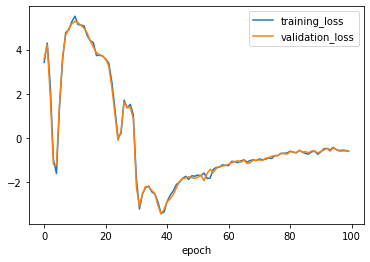

In [31]:
generator.history[['training_loss', 'validation_loss']].plot()

## Test data evaluation
Here we see the comparison of the real profiles with the synthetically generated ones using 200 daily profiles that the GAN has never seen. You can see that the synthetically generated data does not always maintain the conditional variables exactly, but does generate a large variety of realistic solar profiles

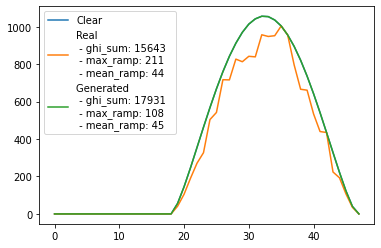

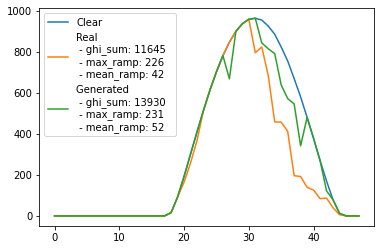

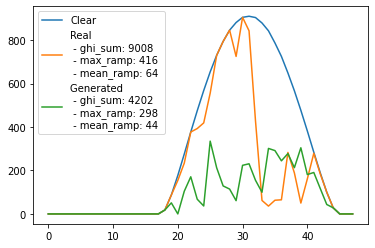

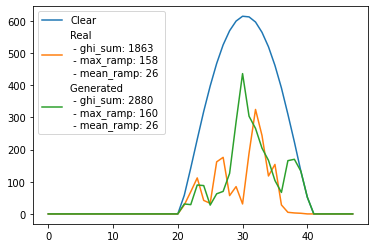

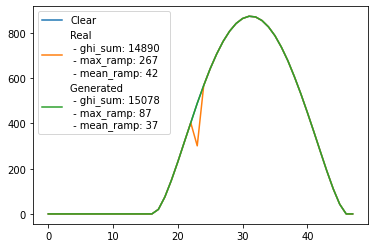

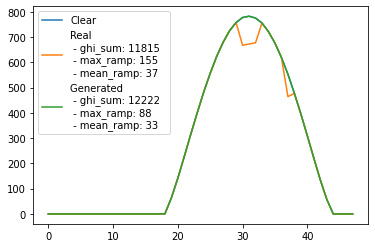

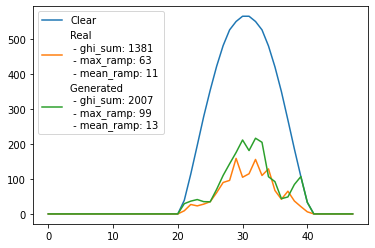

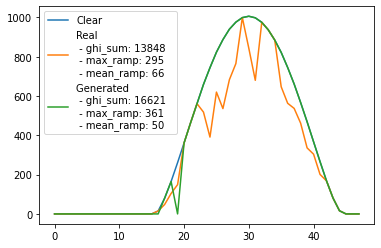

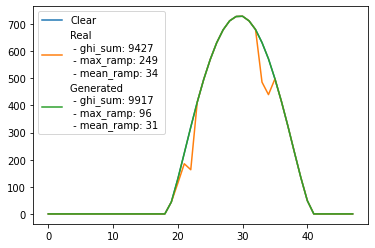

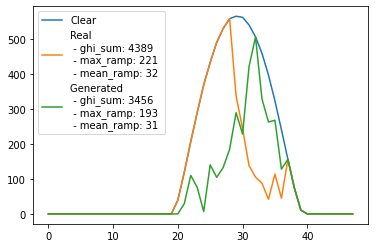

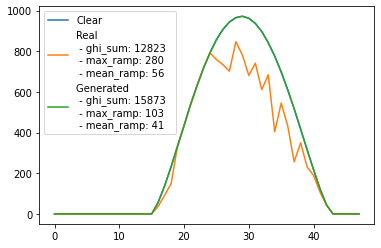

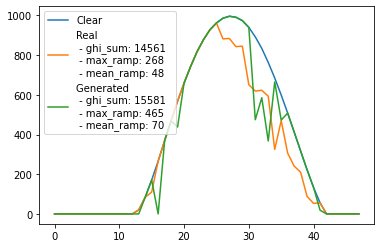

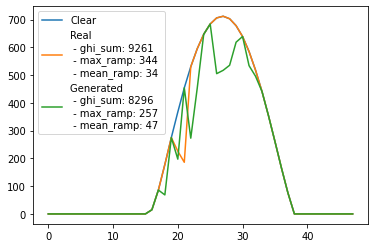

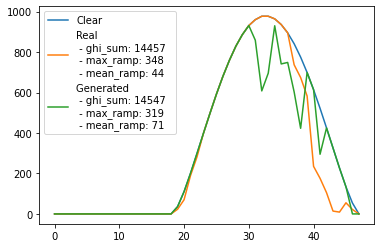

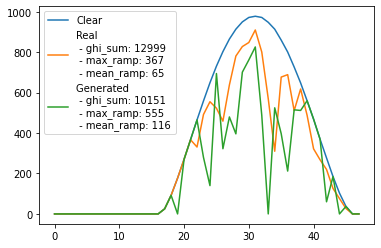

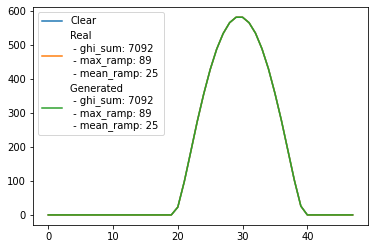

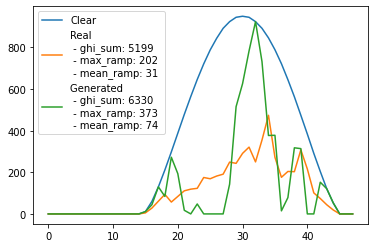

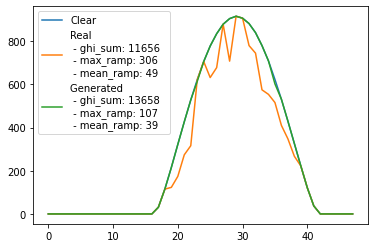

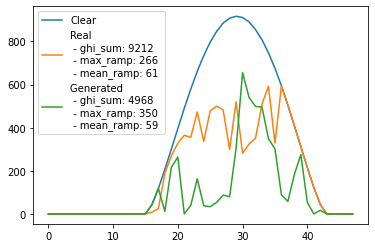

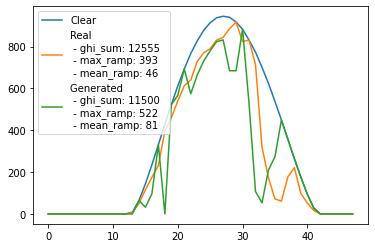

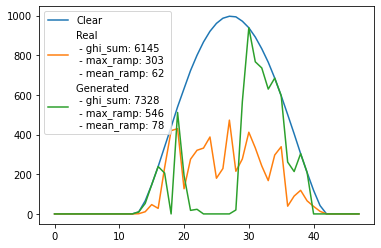

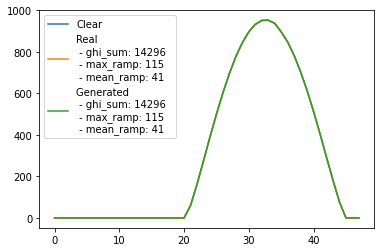

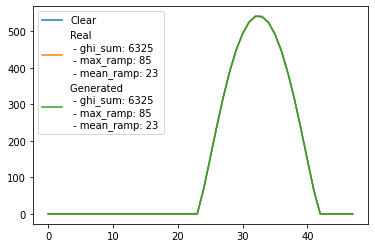

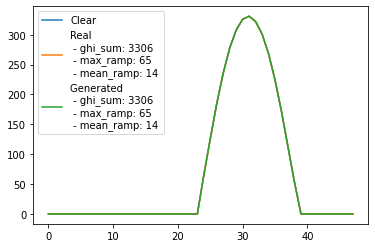

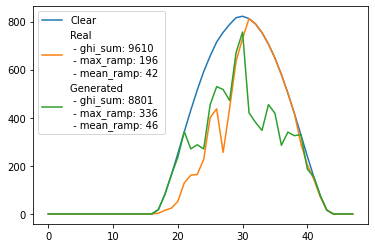

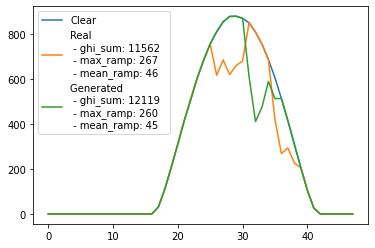

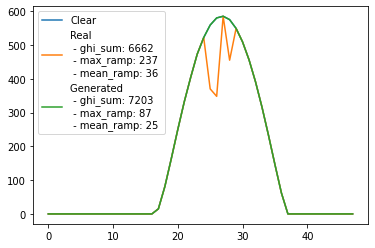

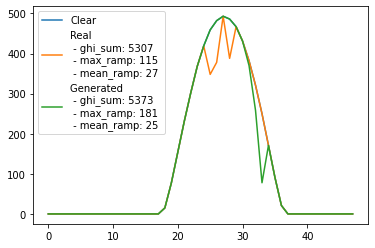

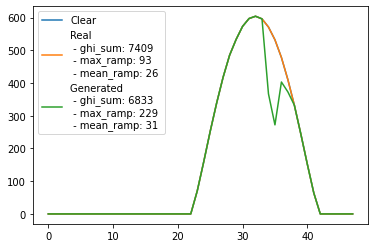

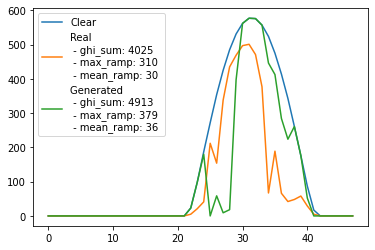

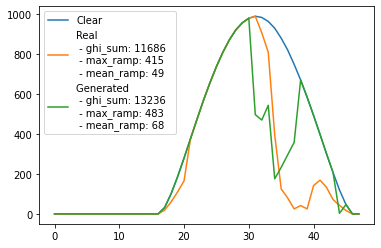

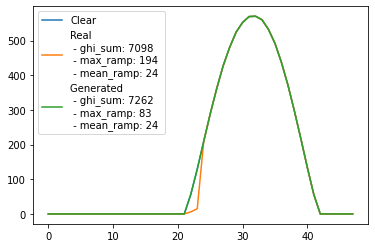

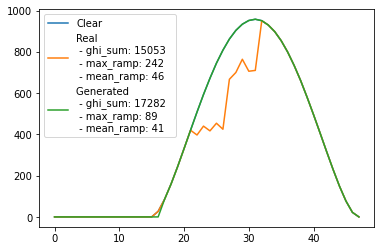

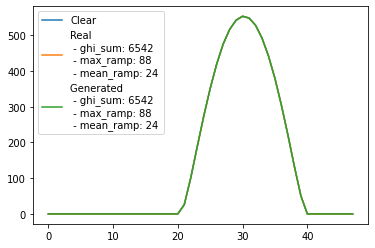

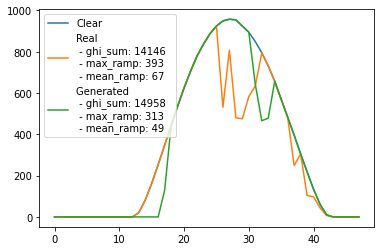

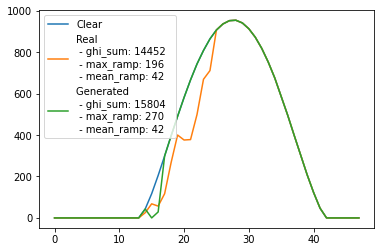

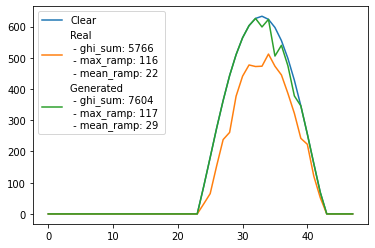

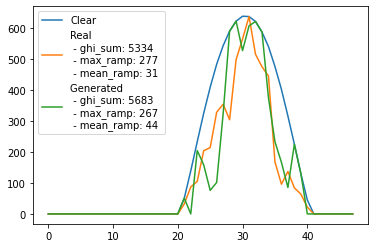

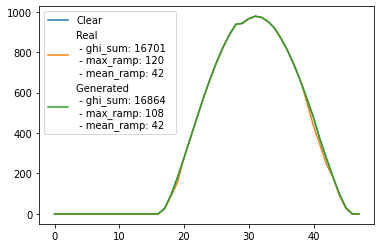

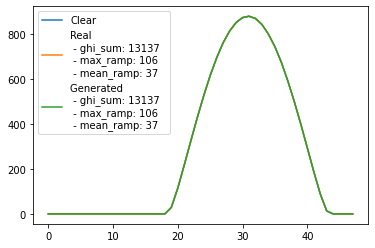

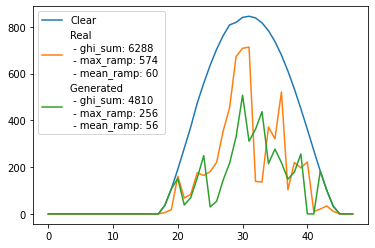

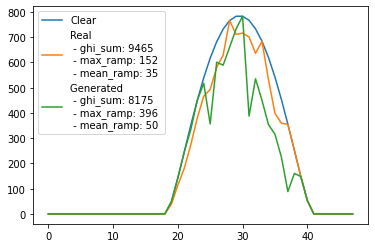

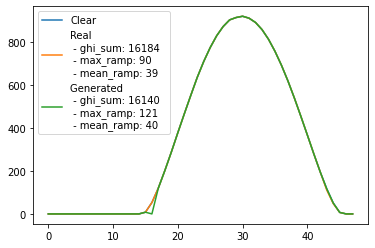

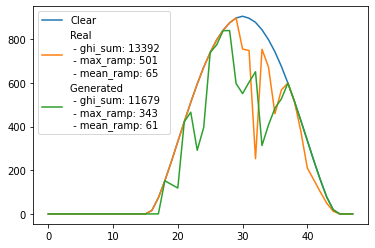

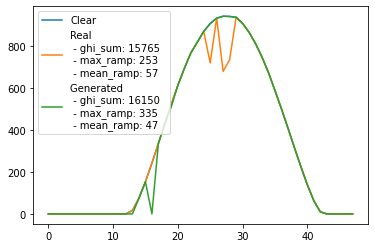

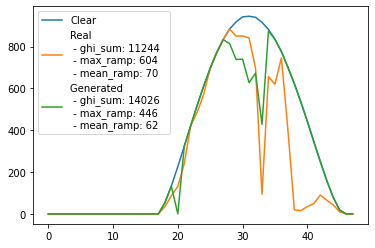

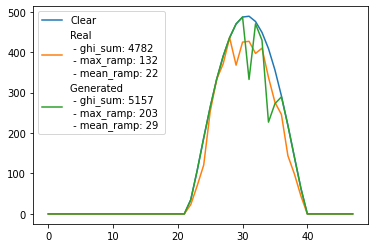

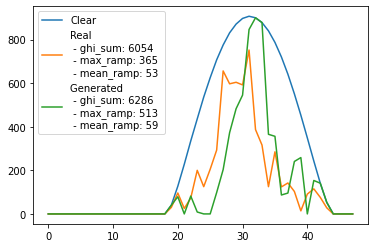

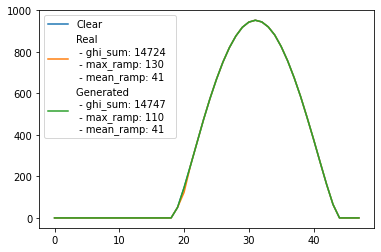

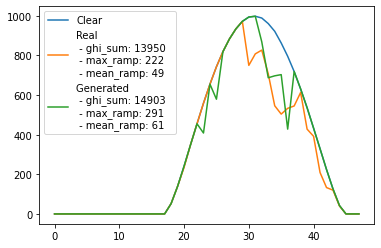

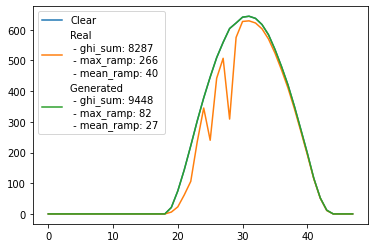

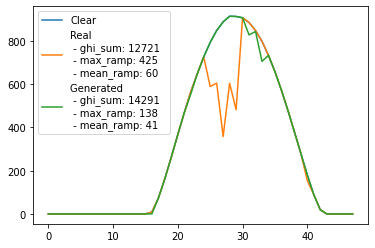

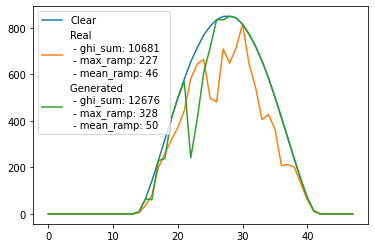

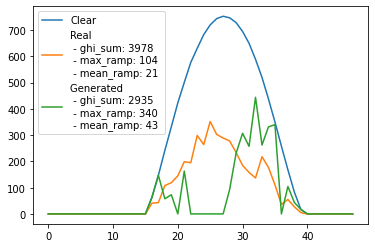

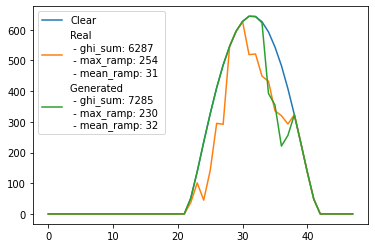

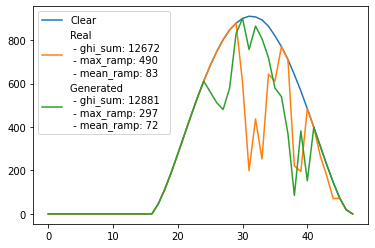

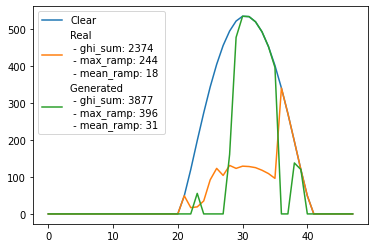

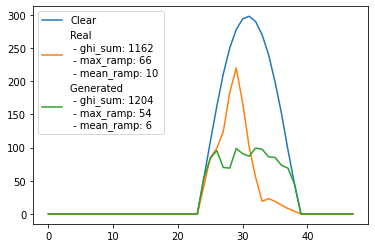

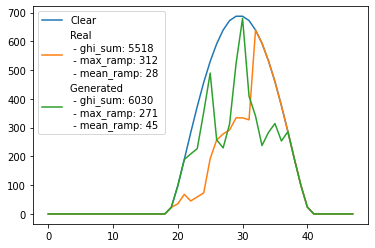

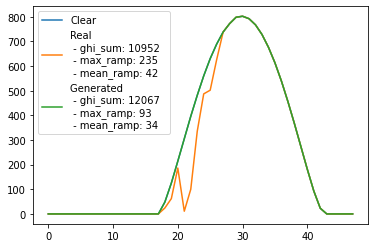

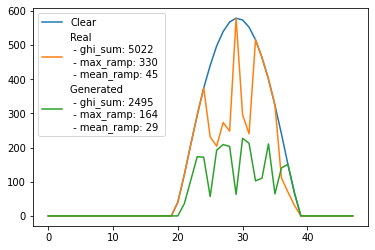

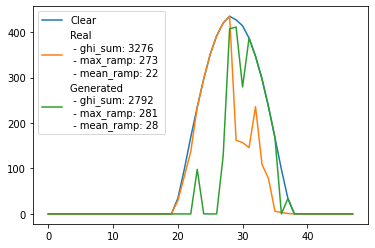

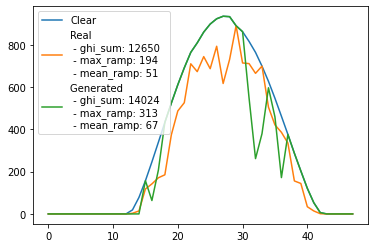

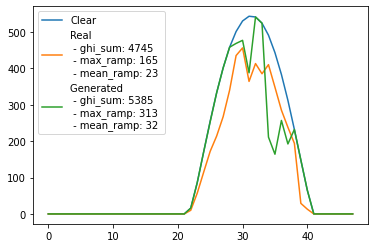

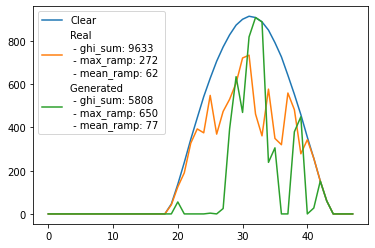

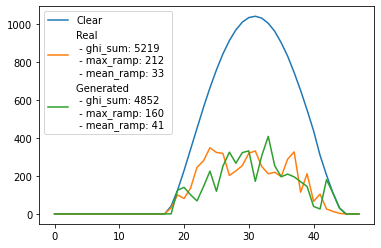

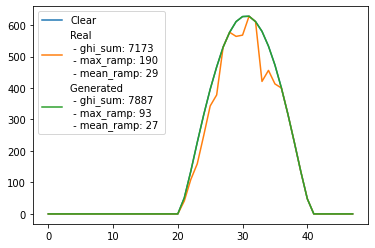

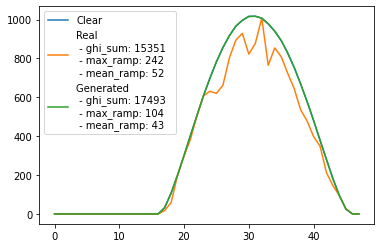

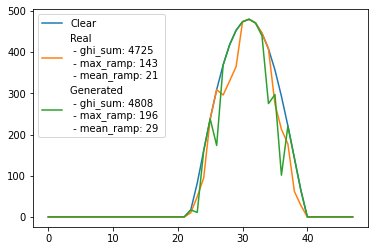

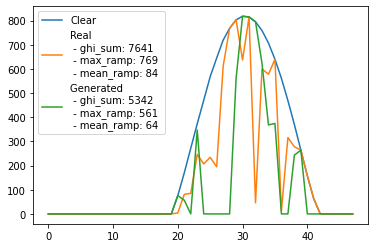

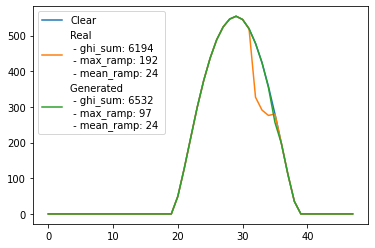

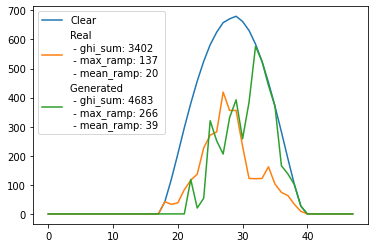

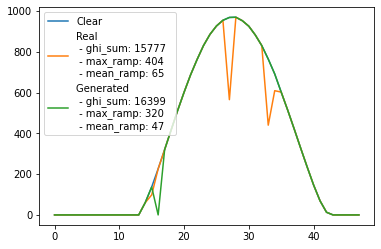

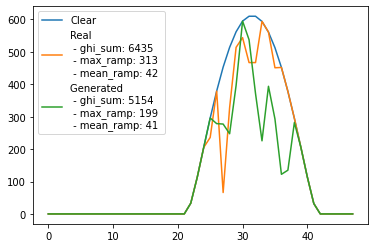

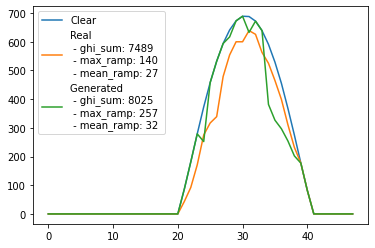

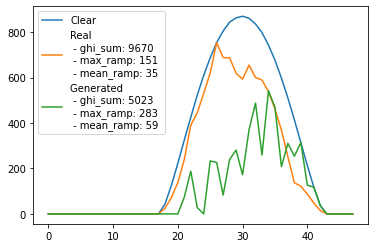

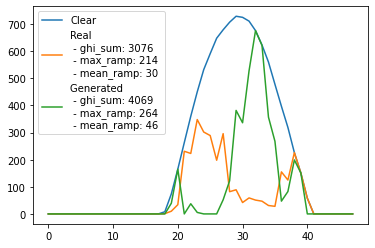

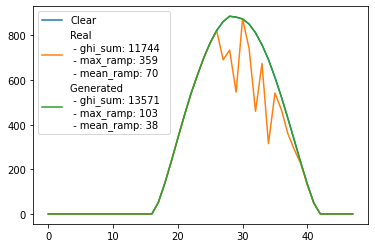

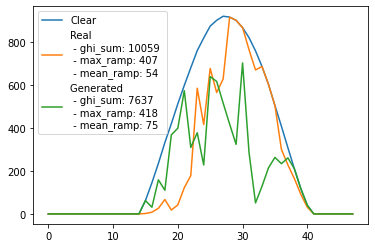

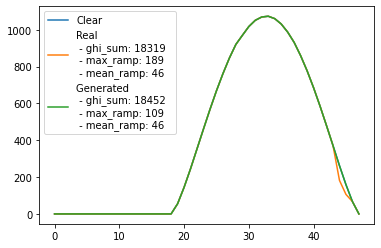

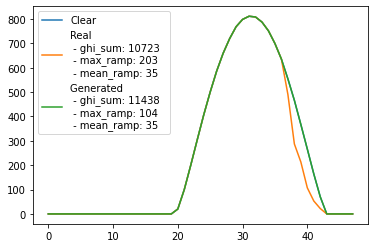

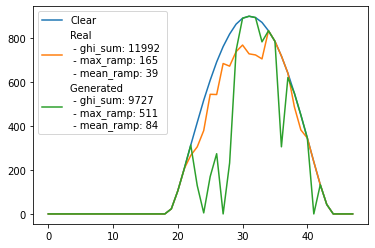

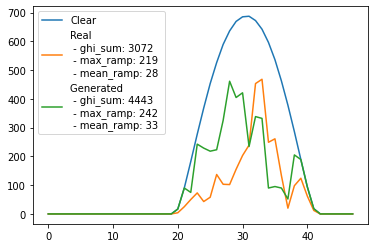

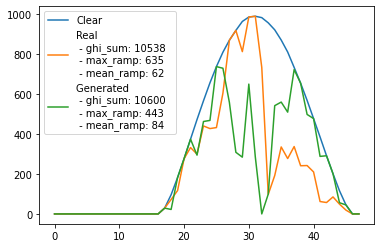

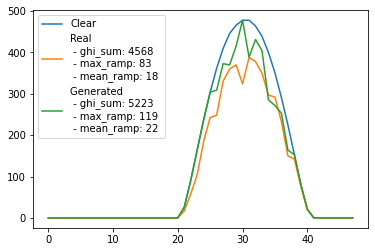

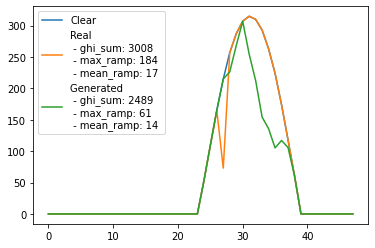

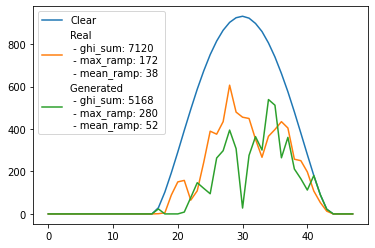

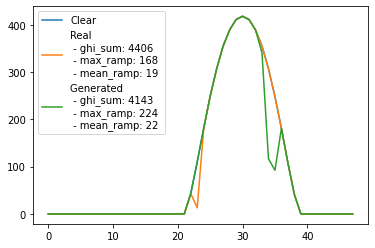

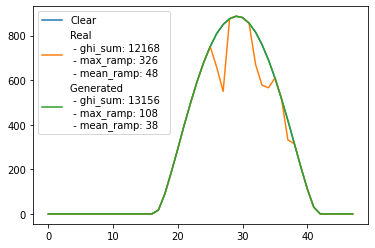

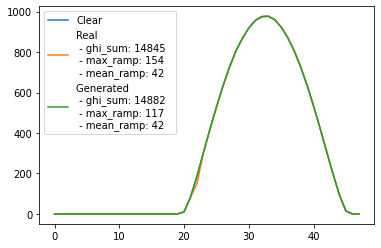

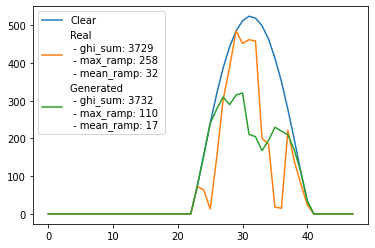

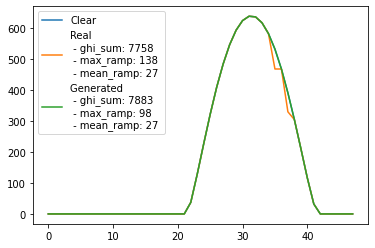

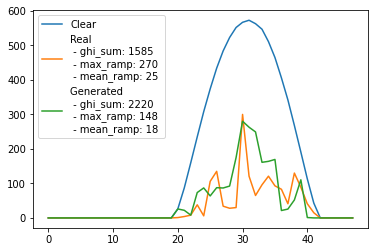

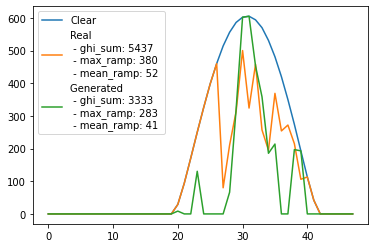

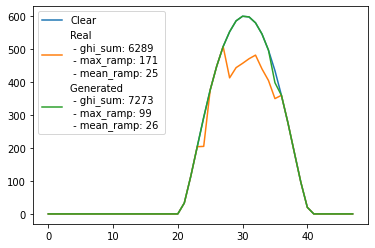

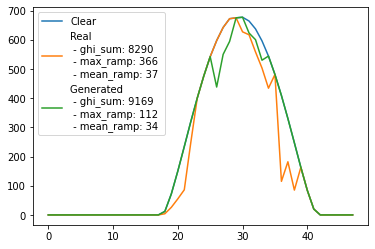

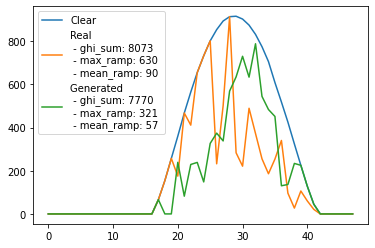

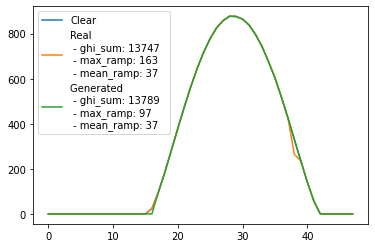

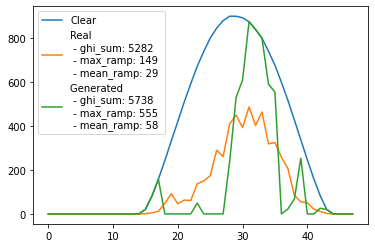

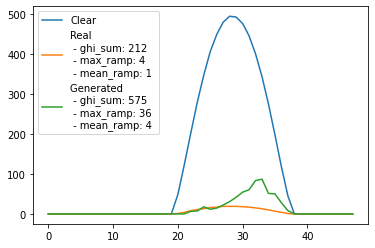

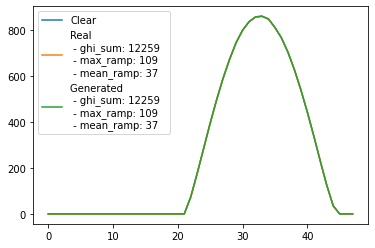

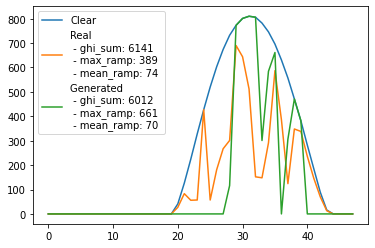

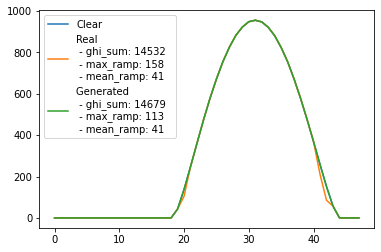

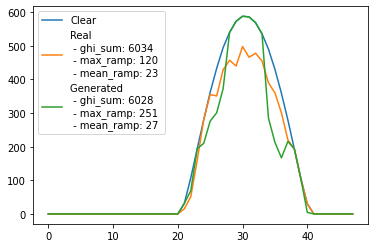

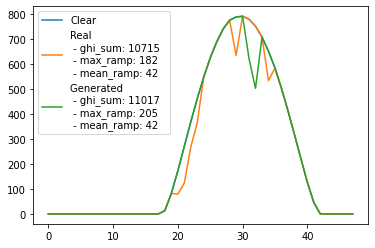

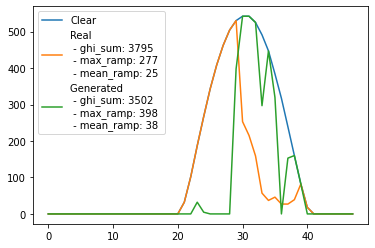

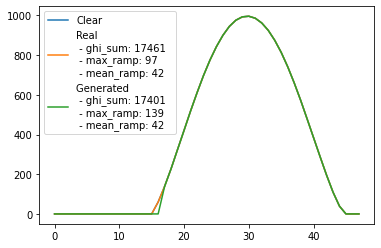

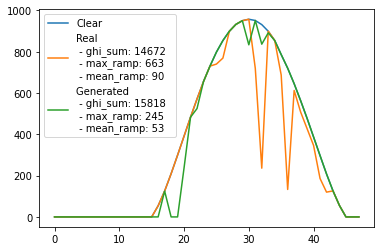

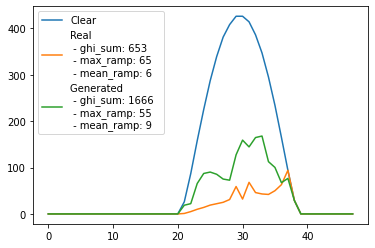

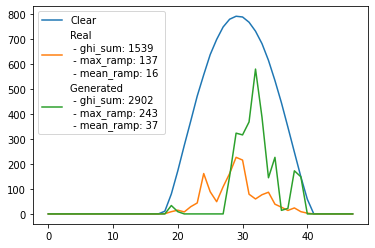

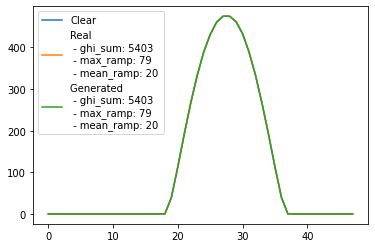

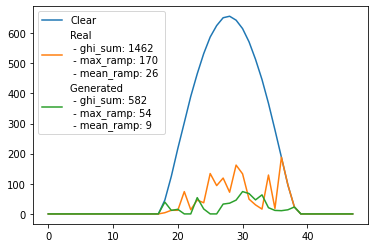

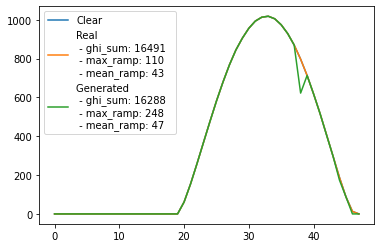

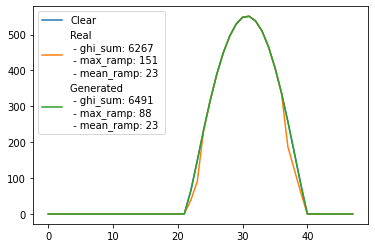

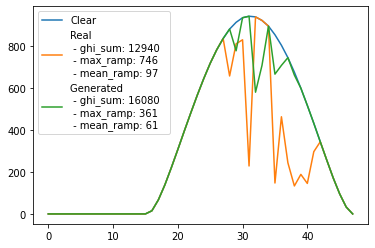

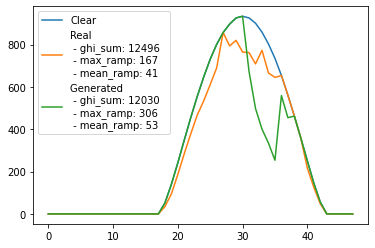

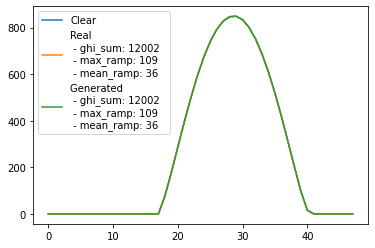

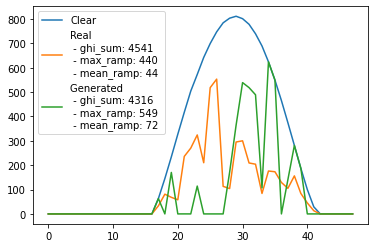

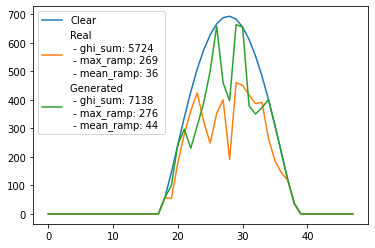

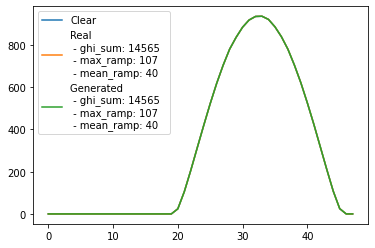

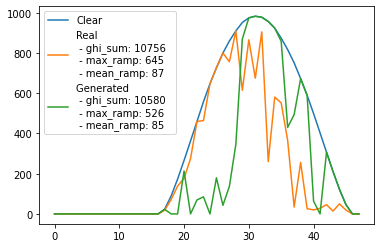

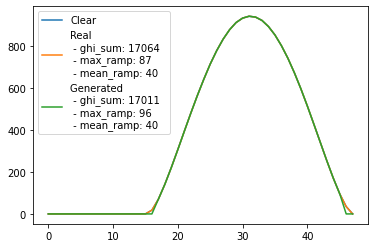

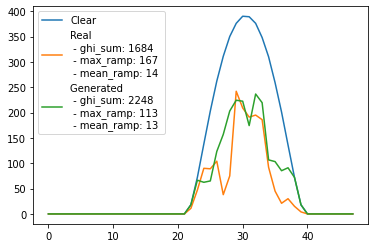

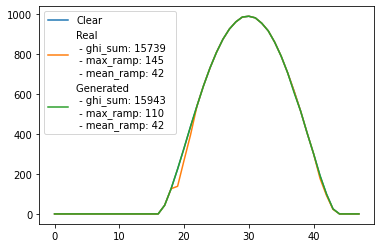

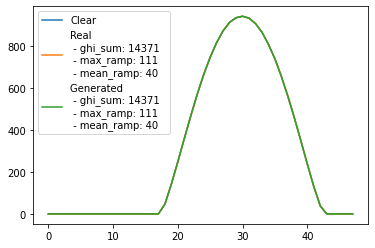

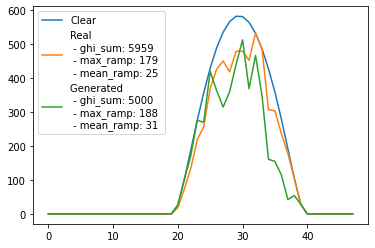

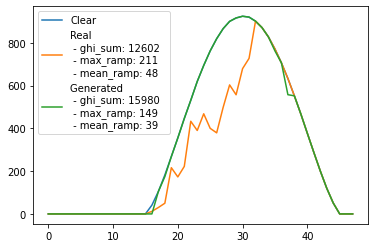

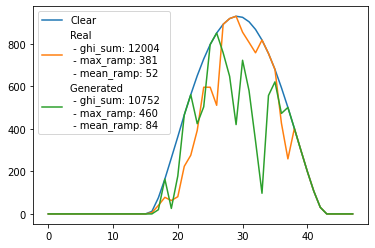

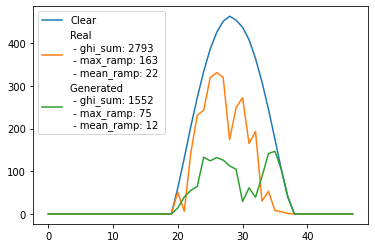

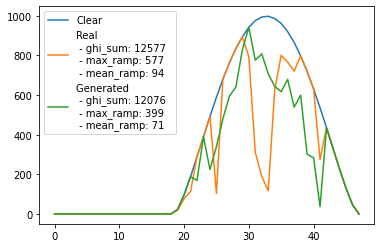

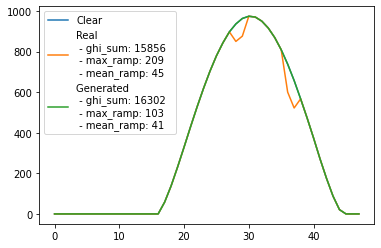

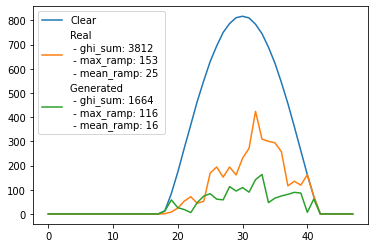

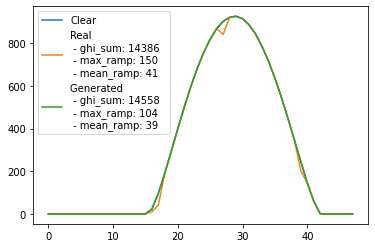

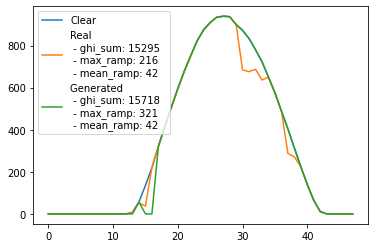

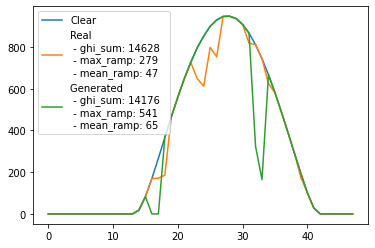

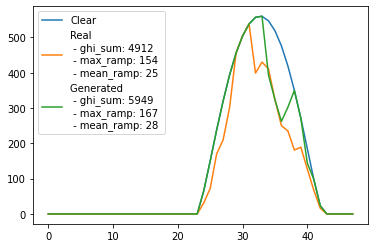

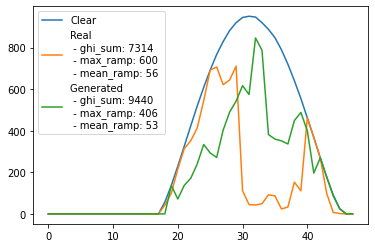

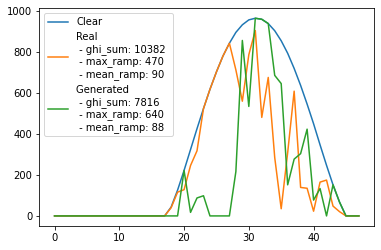

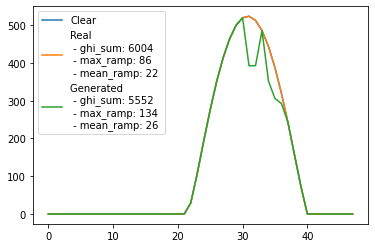

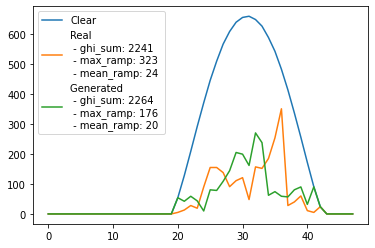

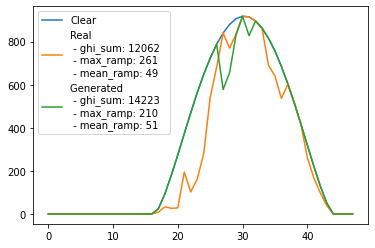

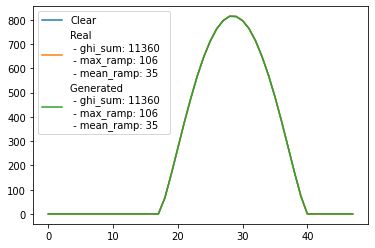

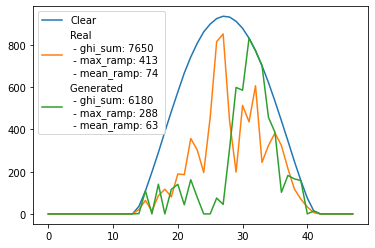

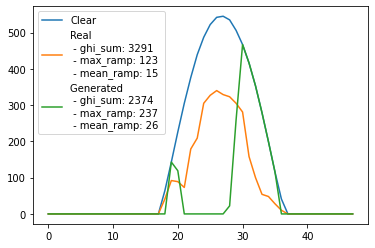

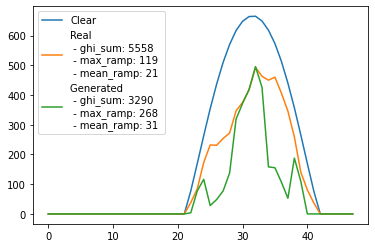

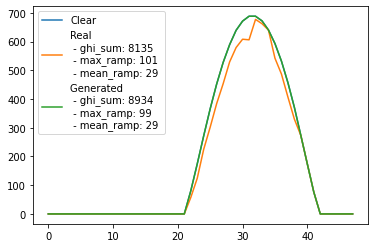

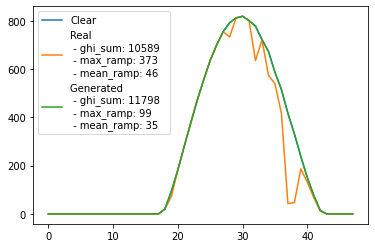

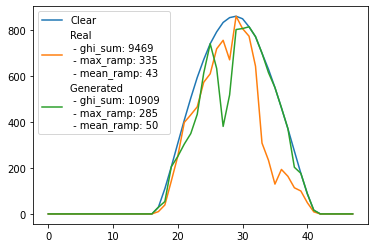

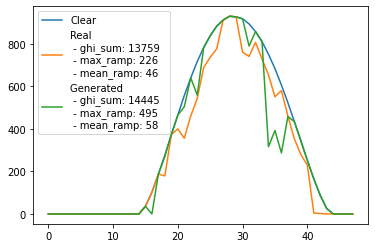

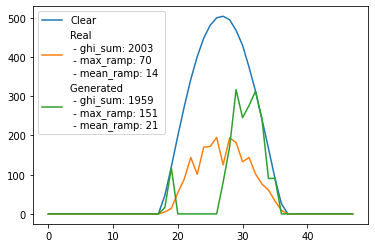

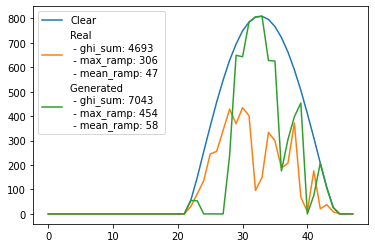

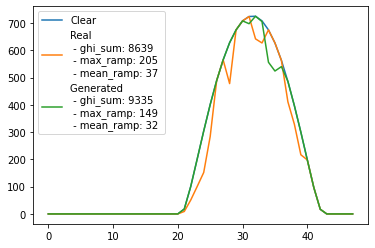

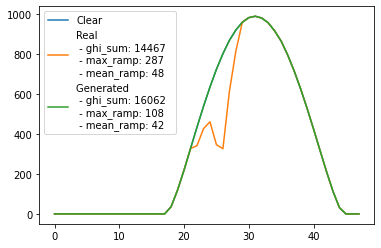

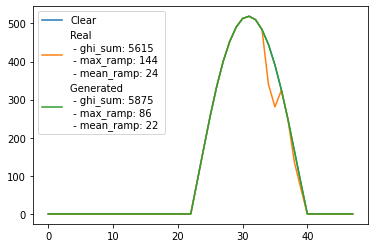

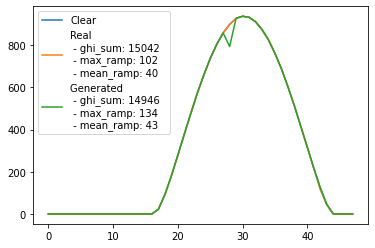

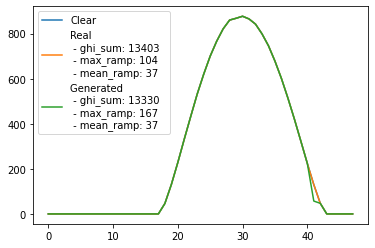

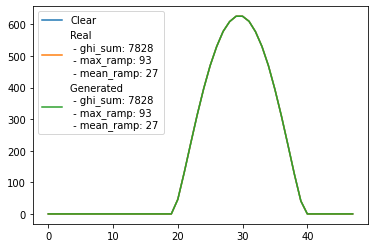

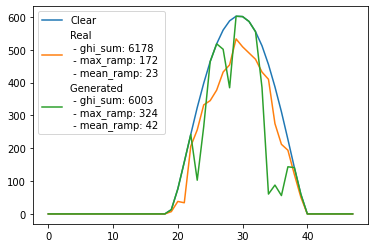

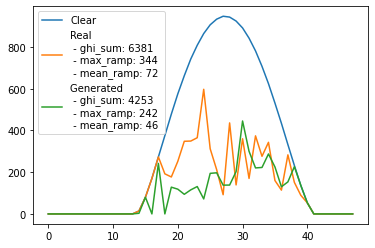

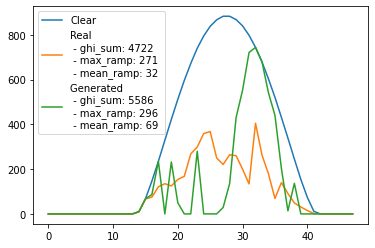

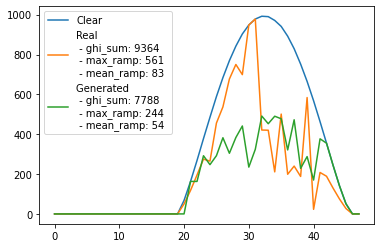

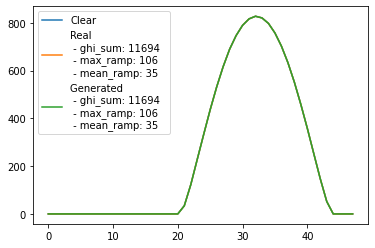

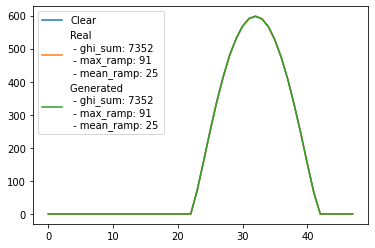

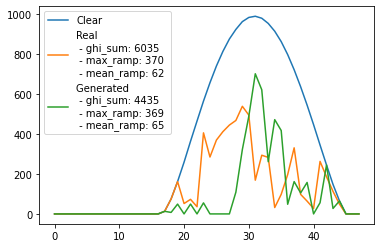

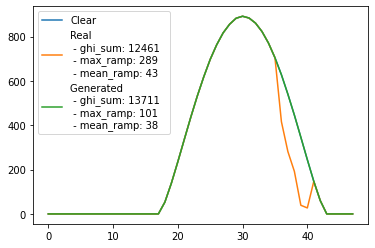

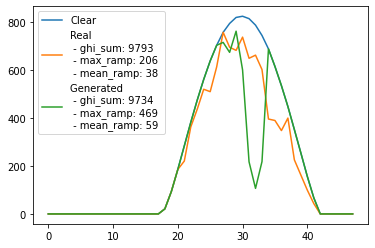

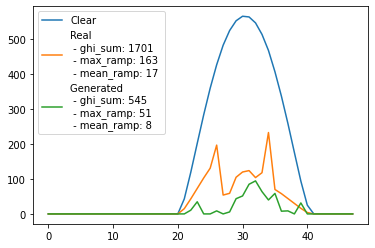

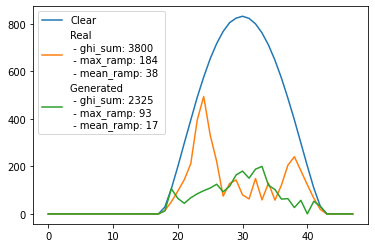

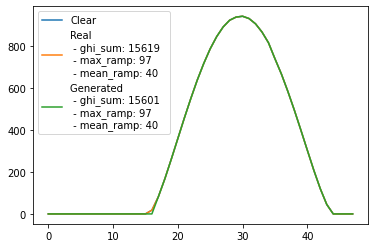

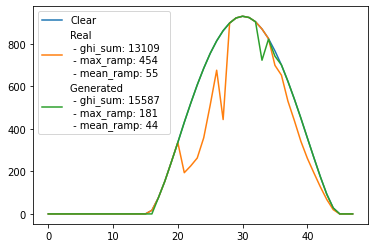

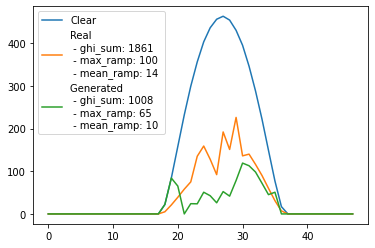

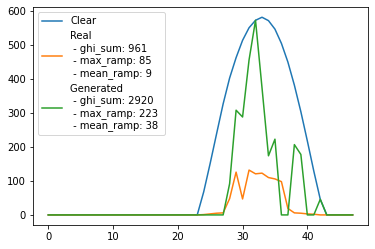

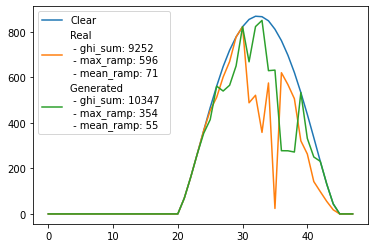

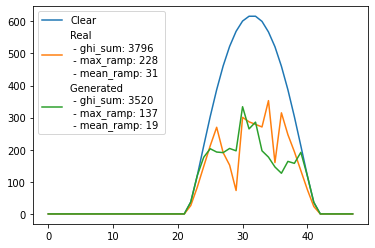

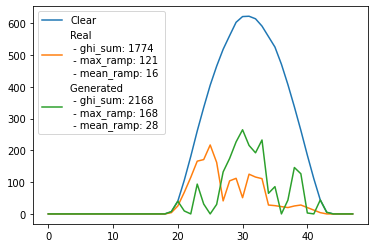

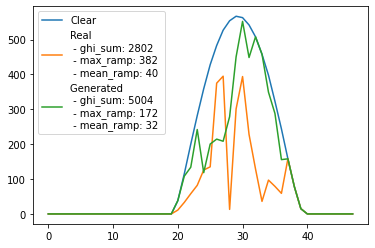

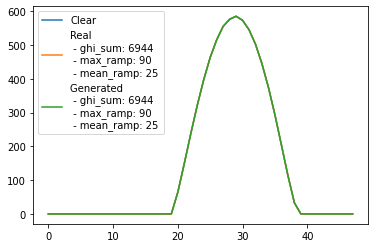

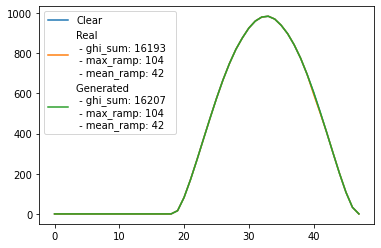

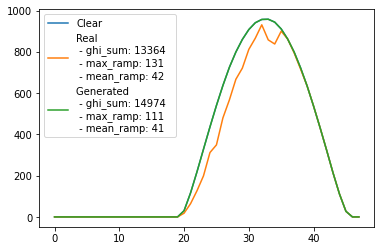

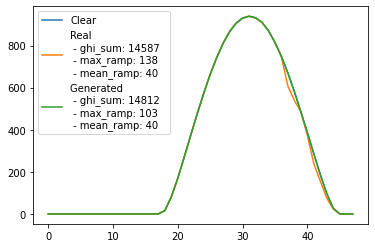

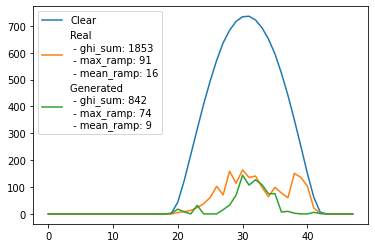

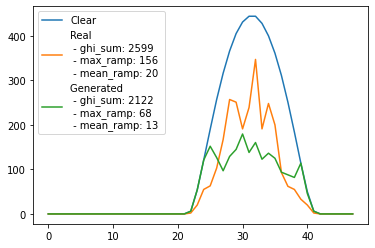

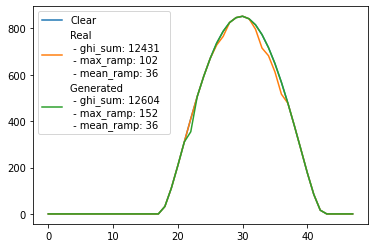

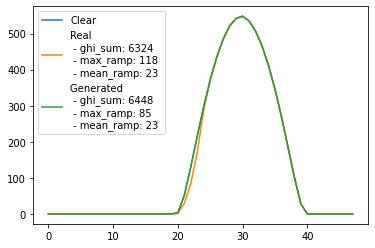

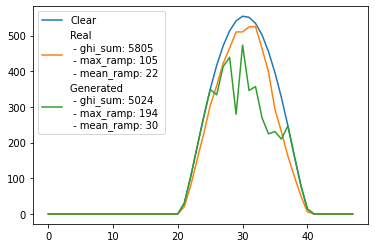

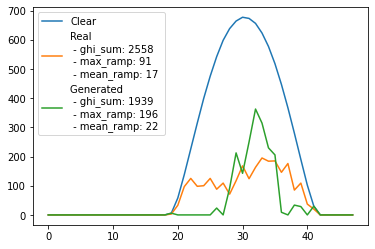

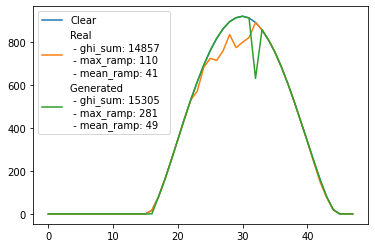

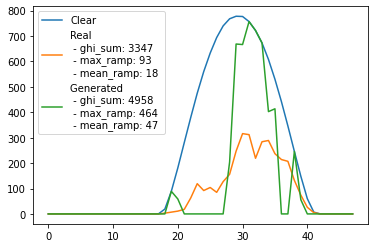

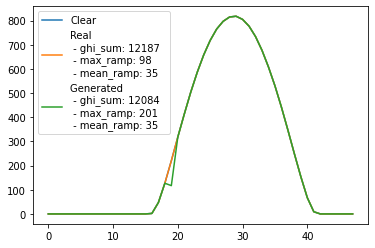

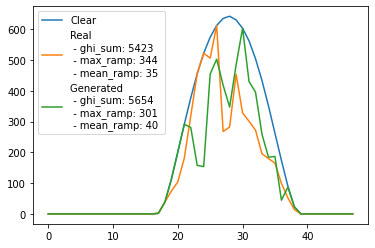

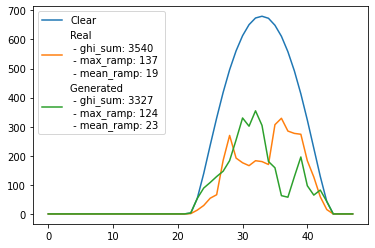

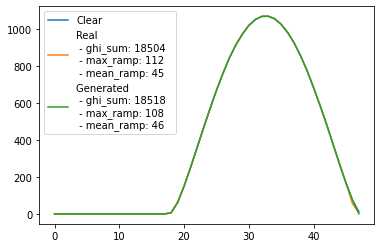

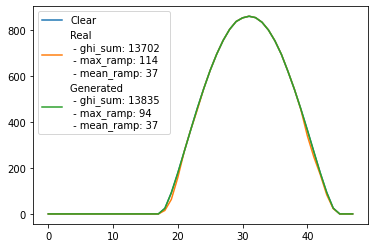

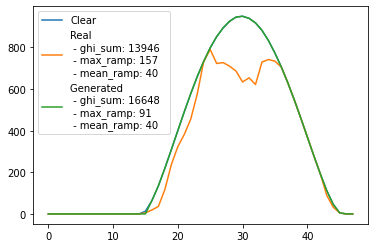

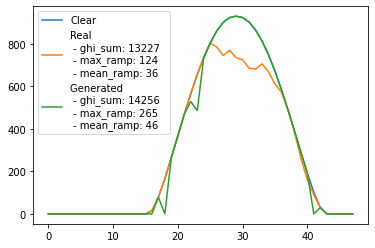

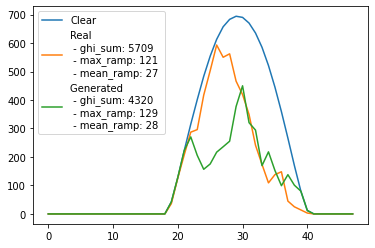

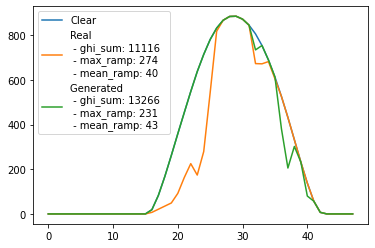

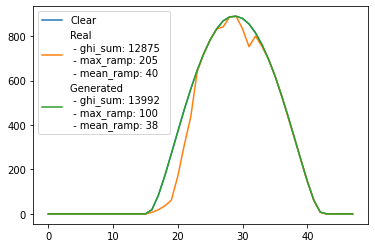

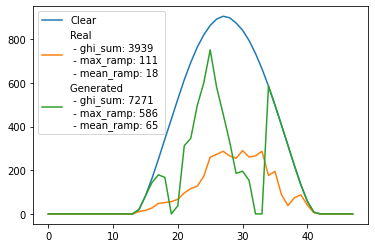

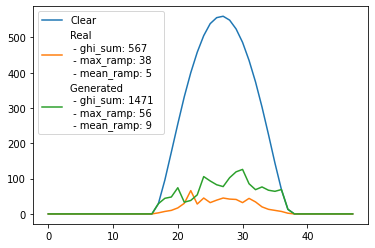

In [32]:
features = test_data[:, :I1]
generated = generator.predict(features)
generated = SolarGan.make_d_features(generated)

for i in range(0, len(test_data), 1):
    plt.plot(test_data[i, 0:48])
    plt.plot(test_data[i, I1:])
    plt.plot(generated[i, 4:])
    plt.legend(['Clear',
                'Real \n - ghi_sum: {:.0f} \n - max_ramp: {:.0f} \n - mean_ramp: {:.0f}'.format(test_data[i, 49], test_data[i, 50], test_data[i, 51]),
                'Generated \n - ghi_sum: {:.0f}  \n - max_ramp: {:.0f} \n - mean_ramp: {:.0f}'.format(generated[i, 1], generated[i, 2], generated[i, 3])])
    plt.show()
    plt.close()

## Discriminator evaluation 

This histogram will be Zero if discriminator is perfect

0.35861617


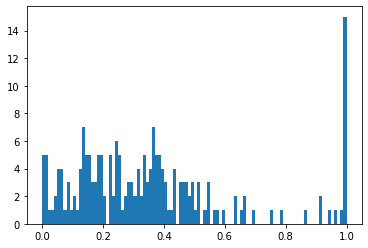

In [33]:
classification = discriminator(generated)
classification = classification.numpy().flatten()
print(classification.mean())
_ = plt.hist(classification, bins=100)

This histogram will be One if the discriminator is perfect

0.4198868


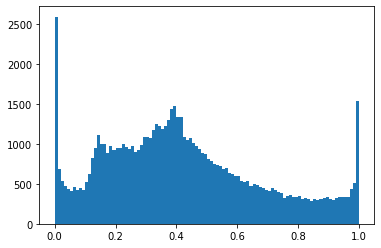

In [34]:
classification = discriminator(real_data[:, I0:]).numpy().flatten()
print(classification.mean())
_ = plt.hist(classification, bins=100)